# Recurrent Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/griverat/Meteo-AI/blob/main/notebooks/4.rnn_datos.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Si usa Google Colab, asegúrese de tener habilitada la GPU para este notebook.**

![gpu_colab](https://github.com/griverat/Meteo-AI/blob/main/images/colab_gpu.png?raw=1)

## Descripción

Este notebook contiene el material a desarrollar durante la sesión de redes neuronales recurrentes. Se presentaran los conceptos básicos del uso de inteligencia artificial capaz de capturar tanto patrones espaciales como temporales en los datos.


## Objetivos

- Entender el concepto de redes neuronales recurrentes
- Comparar el rendimiento de una red neuronal recurrente
- Implementar un modelo de pronóstico de series temporales


In [1]:
# Solo correr esta celda si se usa google colab
# Quitar el comentario (#) a los comandos que comienzan con !

!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=20c92831ce13fca0d9303c04869569271d93abd513bc54cd5ae0a82a5c9069eb
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [2]:
!mkdir data
!wget https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/puerto_inca.csv -O data/puerto_inca.csv

--2024-06-21 20:58:06--  https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/puerto_inca.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 399666 (390K) [text/plain]
Saving to: ‘data/puerto_inca.csv’

data/puerto_inca.cs 100%[===================>] 390.30K  --.-KB/s    in 0.03s   

2024-06-21 20:58:06 (14.1 MB/s) - ‘data/puerto_inca.csv’ saved [399666/399666]



---

## Redes con características temporales

Si bien las redes neuronales convolucionales (CNN) son muy buenas para capturar patrones espaciales, no son tan buenas para capturar patrones temporales en los datos. Para capturar patrones temporales, se pueden usar redes neuronales recurrentes (RNN) o redes neuronales convolucionales 1D (CNN1D). Para comenzar, se mostrará cómo usar redes neuronales recurrentes para predecir series temporales.

### Importar librerías

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import tensorflow as tf
import xarray as xr
from ydata_profiling import ProfileReport

plt.rcParams["font.family"] = "monospace"

In [4]:
def plot_fit(test_label, test_pred, xlim=(15, 45), ylim=(15, 45)):
    coefs_keras = poly.polyfit(test_label.values.flatten(), test_pred, 1)
    ffit_keras = poly.Polynomial(coefs_keras)
    ffit_keras

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(test_label.values, test_pred, s=5)
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")

    x = np.linspace(15, 45, 100)
    y = ffit_keras(x)
    ax.plot(
        x,
        y,
        color="red",
        lw=1,
        label=f"y = {coefs_keras[0]:.2f} + {coefs_keras[1]:.2f}x",
    )

    ax.legend()

    ax.set_title("True vs Pred")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # linea de 45 grados
    ax.plot([15, 45], [15, 45], ls="--", lw=0.5, color="black")

    ax.grid(ls="--", lw=0.5)

## Recurrent Neural Networks

Las redes neuronales recurrentes (RNN) son un tipo de red neuronal que se especializa en capturar patrones temporales en los datos. A diferencia de las CNN, las RNN tienen conexiones recurrentes, lo que significa que la salida de una capa se alimenta de nuevo a la misma capa en el siguiente paso de tiempo. Esto permite que las RNN capturen patrones temporales en los datos.

Para comenzar, vamos a cargar datos de la estacion Puerto Inca ubicada en la provincia de Huanuco, Perú.

In [5]:
station_data = pd.read_csv("data/puerto_inca.csv", skiprows=10)

# renombramos las columnas a algo más amigable
station_data.columns = [
    "date",
    "hour",
    "temp",
    "precip",
    "humidity",
    "wind_dir",
    "wind_speed",
]

# combinamos las columnas de fecha y hora en una sola
station_data["date"] = pd.to_datetime(station_data["date"] + " " + station_data["hour"])
station_data = station_data.drop(columns=["hour"])

# para este ejemplo, solo nos interesa la fecha, temperatura y precipitación
station_data = station_data[["date", "temp", "precip"]]
station_data["temp"] = pd.to_numeric(
    station_data["temp"], errors="coerce", downcast="float"
)
station_data["precip"] = pd.to_numeric(
    station_data["precip"], errors="coerce", downcast="float"
)

# eliminamos las filas con valores faltantes
station_data = station_data.dropna()
station_data = station_data.set_index("date")
station_data.head()

,temp,precip
date,,
2023-04-01 00:00:00,23.400000,0.0
2023-04-01 01:00:00,23.299999,0.0
2023-04-01 02:00:00,23.200001,0.0
2023-04-01 03:00:00,23.299999,0.0
2023-04-01 04:00:00,23.299999,0.0


Exploramos los datos

In [6]:
station_data.describe(exclude=[np.datetime64])

,temp,precip
count,10648.000000,10648.000000
mean,27.067759,0.226860
std,3.865856,1.878195
min,18.299999,0.000000
25%,24.100000,0.000000
50%,25.799999,0.000000
75%,29.799999,0.000000
max,39.599998,48.299999


In [7]:
ProfileReport(station_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Precipitación')

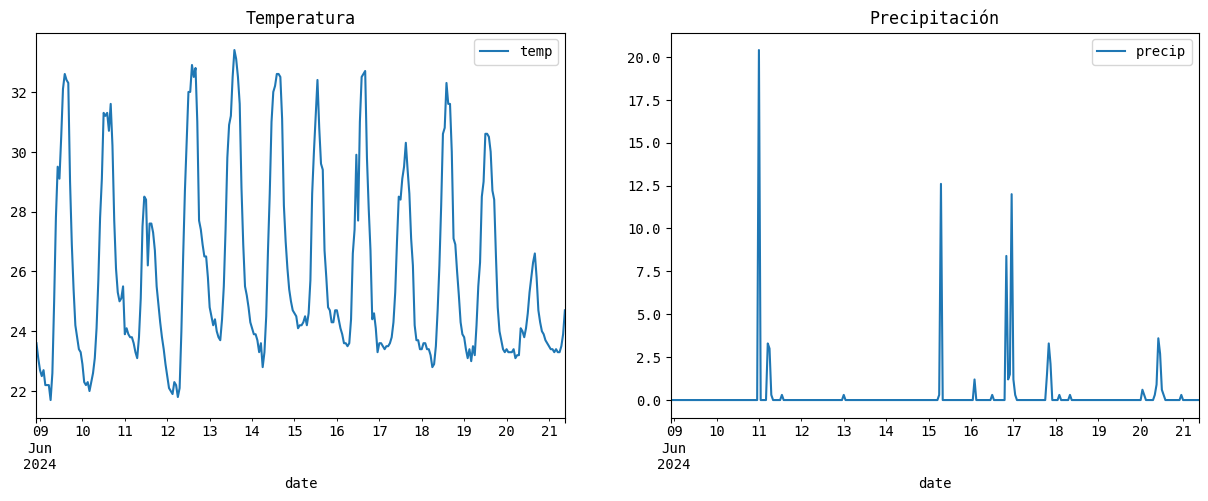

In [10]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
station_data.iloc[-300:].plot(y="temp", ax=ax[0])
ax[0].set_title("Temperatura")

station_data.iloc[-300:].plot(y="precip", ax=ax[1])
ax[1].set_title("Precipitación")

Ahora que los datos estan listo, usaremos Keras para crear nuestro modelo de RNN. Primero, guardamos una copia de nuestros datos originales para poder reutilizarlos más adelante.

In [11]:
station_data_orig = station_data.copy(deep=True)

### Many-to-One RNN

En este caso, vamos a usar una red neuronal recurrente (RNN) para predecir la temperatura de la siguiente hora usando los datos de las ultimas 6h. Este es un ejemplo de una arquitectura de red neuronal recurrente de varios a uno.

Preparamos los datos para el modelo

In [12]:
station_data["temp_1h"] = station_data["temp"].shift(1)
station_data["temp_2h"] = station_data["temp"].shift(2)
station_data["temp_3h"] = station_data["temp"].shift(3)
station_data["temp_4h"] = station_data["temp"].shift(4)
station_data["temp_5h"] = station_data["temp"].shift(5)

station_data = station_data.dropna()

station_data.head(6)

,temp,precip,temp_1h,temp_2h,temp_3h,temp_4h,temp_5h
date,,,,,,,
2023-04-01 05:00:00,23.400000,0.0,23.299999,23.299999,23.200001,23.299999,23.400000
2023-04-01 06:00:00,23.400000,0.0,23.400000,23.299999,23.299999,23.200001,23.299999
2023-04-01 07:00:00,23.500000,0.0,23.400000,23.400000,23.299999,23.299999,23.200001
2023-04-01 08:00:00,23.900000,0.0,23.500000,23.400000,23.400000,23.299999,23.299999
2023-04-01 09:00:00,23.700001,0.0,23.900000,23.500000,23.400000,23.400000,23.299999
2023-04-01 10:00:00,25.700001,0.0,23.700001,23.900000,23.500000,23.400000,23.400000


In [13]:
station_data["next_temp"] = station_data["temp"].shift(-1)

# eliminamos la última fila, ya que no tiene un valor para la siguiente temperatura
station_data = station_data.dropna()
station_data.head()

<ipython-input-13-95d217795bdc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data["next_temp"] = station_data["temp"].shift(-1)


,temp,precip,temp_1h,temp_2h,temp_3h,temp_4h,temp_5h,next_temp
date,,,,,,,,
2023-04-01 05:00:00,23.400000,0.0,23.299999,23.299999,23.200001,23.299999,23.400000,23.400000
2023-04-01 06:00:00,23.400000,0.0,23.400000,23.299999,23.299999,23.200001,23.299999,23.500000
2023-04-01 07:00:00,23.500000,0.0,23.400000,23.400000,23.299999,23.299999,23.200001,23.900000
2023-04-01 08:00:00,23.900000,0.0,23.500000,23.400000,23.400000,23.299999,23.299999,23.700001
2023-04-01 09:00:00,23.700001,0.0,23.900000,23.500000,23.400000,23.400000,23.299999,25.700001


Separamos los datos en conjuntos de entrenamiento y prueba

In [14]:
train_size = int(len(station_data) * 0.85)
# el orden va desde la más antigua a la más reciente
input_vars = ["temp_5h", "temp_4h", "temp_3h", "temp_2h", "temp_1h", "temp"]
output_vars = ["next_temp"]
train_data, test_data = (
    station_data[input_vars].iloc[:train_size],
    station_data[output_vars].iloc[train_size:],
)

train_label, test_label = (
    station_data[input_vars].iloc[:train_size],
    station_data[output_vars].iloc[train_size:],
)

# mean = train_data["temp"].mean()
# std = train_data["temp"].std()

# train_data = (train_data - mean) / std
# test_data = (test_data - mean) / std

Ahora definimos el modelo de RNN usando Keras.

In [21]:
many_to_one_rnn = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(8, input_shape=(6, 1), return_sequences=True),
        tf.keras.layers.Dense(1),
    ]
)

many_to_one_rnn.compile(optimizer="adam", loss="mean_squared_error")
many_to_one_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 6, 8)              80        
                                                                 
 dense_1 (Dense)             (None, 6, 1)              9         
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=10
    )
]

history = many_to_one_rnn.fit(
    train_data.values.reshape(-1, 6, 1),
    train_label.values,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
)

Epoch 1/200
255/255 [==============================] - 3s 8ms/step - loss: 597.8285 - val_loss: 538.3441
Epoch 2/200
255/255 [==============================] - 2s 7ms/step - loss: 467.4930 - val_loss: 442.7311
Epoch 3/200
255/255 [==============================] - 2s 7ms/step - loss: 382.4400 - val_loss: 362.2505
Epoch 4/200
255/255 [==============================] - 3s 12ms/step - loss: 309.8538 - val_loss: 293.4483
Epoch 5/200
255/255 [==============================] - 3s 11ms/step - loss: 248.3235 - val_loss: 235.1859
Epoch 6/200
255/255 [==============================] - 2s 7ms/step - loss: 196.6596 - val_loss: 186.3617
Epoch 7/200
255/255 [==============================] - 2s 7ms/step - loss: 153.8198 - val_loss: 145.9718
Epoch 8/200
255/255 [==============================] - 2s 7ms/step - loss: 118.8093 - val_loss: 113.0382
Epoch 9/200
255/255 [==============================] - 2s 7ms/step - loss: 90.6762 - val_loss: 86.6466
Epoch 10/200
255/255 [==============================] -

In [23]:
mse = many_to_one_rnn.evaluate(test_data.values.reshape(-1, 1, 1), test_label.values)
print(f"Mean Squared Error: {mse:.2f}")

50/50 [==============================] - 0s 2ms/step - loss: 0.0184
Mean Squared Error: 0.02


50/50 [==============================] - 0s 2ms/step


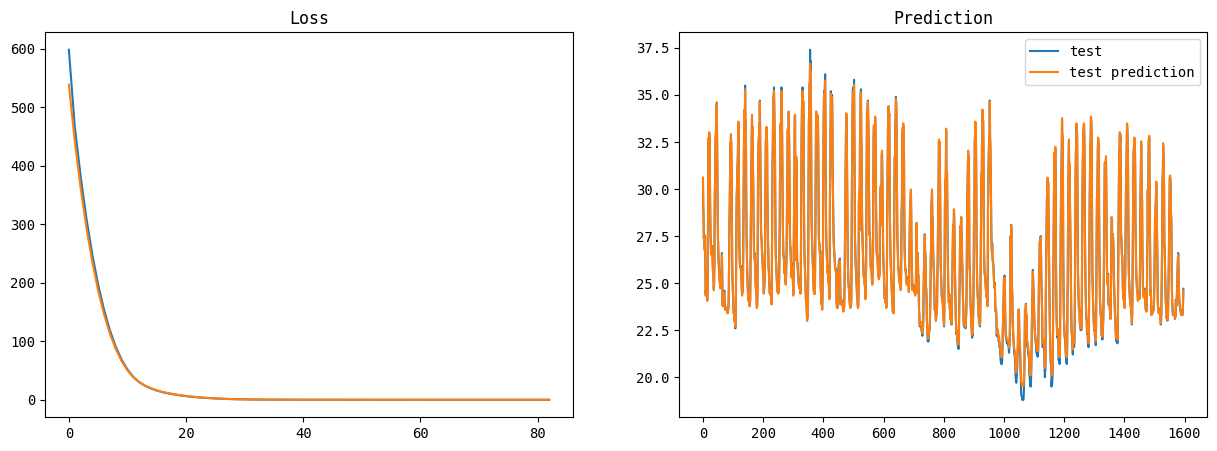

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="validation")
axs[0].set_title("Loss")

test_pred = many_to_one_rnn.predict(test_data.values.reshape(-1, 1)).flatten()
axs[1].plot(test_label.values, label="test")
axs[1].plot(test_pred, label="test prediction")
axs[1].set_title("Prediction")
axs[1].legend()

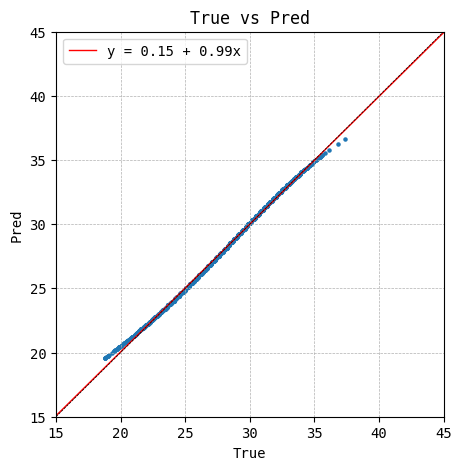

In [25]:
plot_fit(test_label, test_pred)

Como podemos ver, tan solo definir un modelo simple de RNN con datos de entrada de 6 horas y una capa densa de salida nos da unos resultados bastante buenos. Pese a que no le hemos dado informacion al modelo de la estacionalidad de los datos, este ha sido capaz de capturar los patrones temporales en los datos y hacer una buena prediccion de la temperatura.

Podemos probar con LSTM y GRU para ver si obtenemos mejores resultados.

In [26]:
many_to_one_lstm = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(8, input_shape=(6, 1), return_sequences=True),
        tf.keras.layers.Dense(1),
    ]
)

many_to_one_lstm.compile(optimizer="adam", loss="mean_squared_error")
many_to_one_lstm.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=10
    )
]

history = many_to_one_lstm.fit(
    train_data.values.reshape(-1, 6, 1),
    train_label.values,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 8)              320       
                                                                 
 dense_2 (Dense)             (None, 6, 1)              9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
255/255 [==============================] - 4s 6ms/step - loss: 714.1483 - val_loss: 668.7013
Epoch 2/50
255/255 [==============================] - 1s 5ms/step - loss: 572.6233 - val_loss: 501.4251
Epoch 3/50
255/255 [==============================] - 1s 5ms/step - loss: 426.9635 - val_loss: 400.7683
Epoch 4/50
255/255 [==============================] - 1s 5ms/step - loss: 345.0388 - val_loss: 327.9620
Epoc

In [27]:
mse = many_to_one_lstm.evaluate(test_data.values.reshape(-1, 1, 1), test_label.values)
print(f"Mean Squared Error: {mse:.2f}")

50/50 [==============================] - 1s 3ms/step - loss: 0.3249
Mean Squared Error: 0.32


50/50 [==============================] - 0s 2ms/step


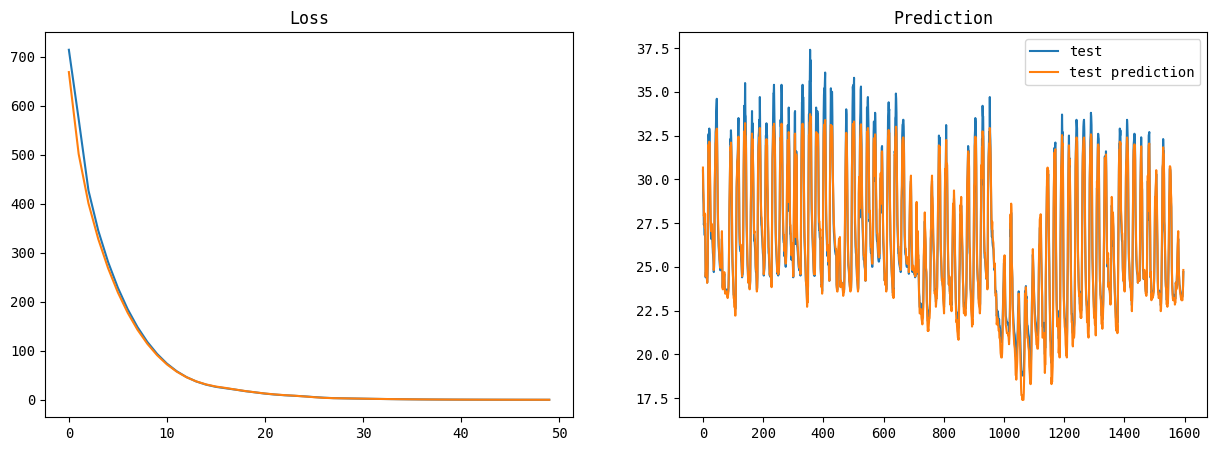

In [29]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="validation")
axs[0].set_title("Loss")

test_pred = many_to_one_lstm.predict(test_data.values.reshape(-1, 1)).flatten()
axs[1].plot(test_label.values, label="test")
axs[1].plot(test_pred, label="test prediction")
axs[1].set_title("Prediction")
axs[1].legend()

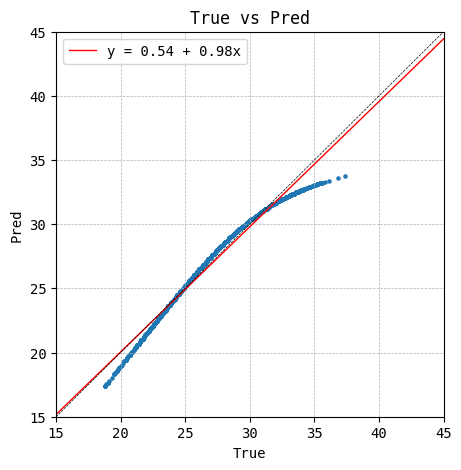

In [30]:
plot_fit(test_label, test_pred)

## Ejericio
La capa Gate Recurrent Unit (GRU) es una variante de la capa LSTM que es más simple y más rápida de entrenar. La GRU tiene menos parámetros que la LSTM y, en general, se comporta de manera similar. En este ejercicio, vamos a probar con una red GRU y comparar los resultados con los obtenidos con la red LSTM y RNN.

Para usar la capa GRU en Keras, simplemente reemplace `LSTM` por `GRU` en la definición de la capa recurrente.

```python
model.add(tf.keras.layers.GRU(units=8, input_shape=(6, 1)))
```

1. Prueba con una red GRU y compara los resultados con los obtenidos con la red LSTM y RNN.

2. Intente cambiar la cantidad de unidades en la capa recurrente y vea cómo afecta el rendimiento del modelo.

3. Hemos estado usando `return_sequences=True` en la capa recurrente. ¿Qué sucede si cambiamos esto a `False`? ¿A qué se debe el cambio en el rendimiento del modelo?

In [31]:
# code here
many_to_one_gru = tf.keras.models.Sequential(
    [
        tf.keras.layers.GRU(8, input_shape=(6, 1), return_sequences=True),
        tf.keras.layers.Dense(1),
    ]
)

many_to_one_gru.compile(optimizer="adam", loss="mean_squared_error")
many_to_one_gru.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=10
    )
]

history = many_to_one_gru.fit(
    train_data.values.reshape(-1, 6, 1),
    train_label.values,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 8)              264       
                                                                 
 dense_3 (Dense)             (None, 6, 1)              9         
                                                                 
Total params: 273 (1.07 KB)
Trainable params: 273 (1.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
255/255 [==============================] - 3s 6ms/step - loss: 616.7181 - val_loss: 509.1489
Epoch 2/50
255/255 [==============================] - 1s 5ms/step - loss: 438.0320 - val_loss: 413.5128
Epoch 3/50
255/255 [==============================] - 1s 5ms/step - loss: 357.0694 - val_loss: 339.3618
Epoch 4/50
255/255 [==============================] - 1s 4ms/step - loss: 253.9273 - val_loss: 228.8172
Epoc

In [32]:
mse = many_to_one_gru.evaluate(test_data.values.reshape(-1, 1, 1), test_label.values)
print(f"Mean Squared Error: {mse:.2f}")

50/50 [==============================] - 1s 3ms/step - loss: 0.0118
Mean Squared Error: 0.01


50/50 [==============================] - 1s 3ms/step


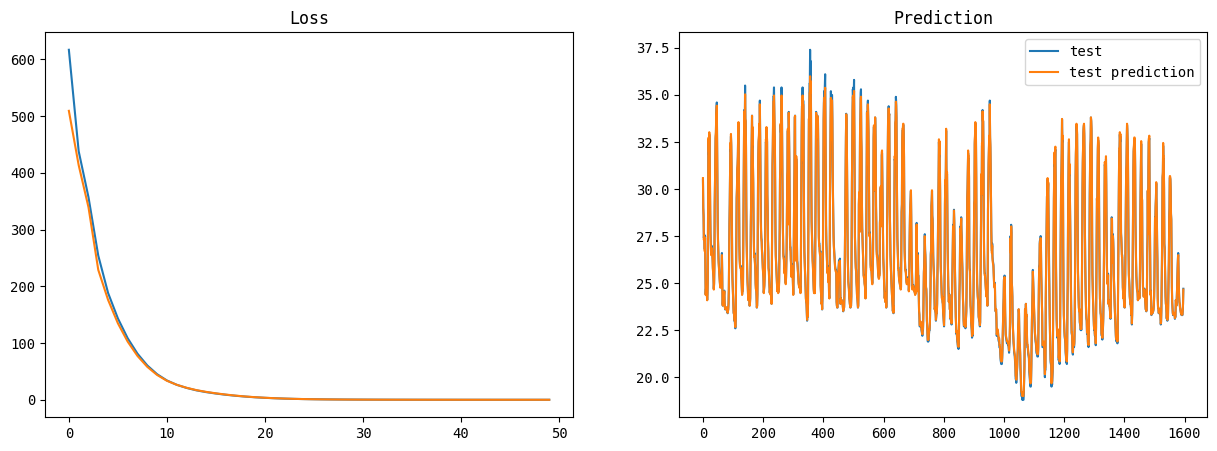

In [34]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="validation")
axs[0].set_title("Loss")

test_pred = many_to_one_gru.predict(test_data.values.reshape(-1, 1)).flatten()
axs[1].plot(test_label.values, label="test")
axs[1].plot(test_pred, label="test prediction")
axs[1].set_title("Prediction")
axs[1].legend()

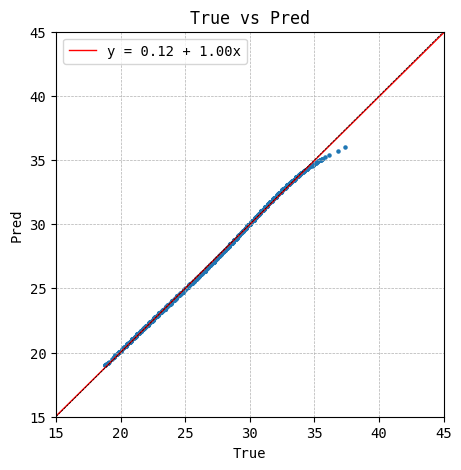

In [35]:
plot_fit(test_label, test_pred)

### Many-to-Many RNN

Ahora vamos a probar una arquitectura de red neuronal recurrente de varios a varios. En este caso, vamos a usar una red neuronal recurrente (RNN) para predecir la temperatura de las siguientes 6 horas usando los datos de las ultimas 6h.

Vamos a hacer que la red neuronal pronostique los siguientes 6 datos de temperatura al mismo tiempo.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1"></img>

Preparamos los datos para el modelo

In [36]:
station_data_many = station_data.copy(deep=True)
station_data_many

,temp,precip,temp_1h,temp_2h,temp_3h,temp_4h,temp_5h,next_temp
date,,,,,,,,
2023-04-01 05:00:00,23.400000,0.0,23.299999,23.299999,23.200001,23.299999,23.400000,23.400000
2023-04-01 06:00:00,23.400000,0.0,23.400000,23.299999,23.299999,23.200001,23.299999,23.500000
2023-04-01 07:00:00,23.500000,0.0,23.400000,23.400000,23.299999,23.299999,23.200001,23.900000
2023-04-01 08:00:00,23.900000,0.0,23.500000,23.400000,23.400000,23.299999,23.299999,23.700001
2023-04-01 09:00:00,23.700001,0.0,23.900000,23.500000,23.400000,23.400000,23.299999,25.700001
...,...,...,...,...,...,...,...,...
2024-06-21 04:00:00,23.400000,0.0,23.299999,23.400000,23.400000,23.500000,23.600000,23.299999
2024-06-21 05:00:00,23.299999,0.0,23.400000,23.299999,23.400000,23.400000,23.500000,23.299999
2024-06-21 06:00:00,23.299999,0.0,23.299999,23.400000,23.299999,23.400000,23.400000,23.500000


In [37]:
station_data_many["next_temp_2h"] = station_data_many["temp"].shift(-2)
station_data_many["next_temp_3h"] = station_data_many["temp"].shift(-3)
station_data_many["next_temp_4h"] = station_data_many["temp"].shift(-4)
station_data_many["next_temp_5h"] = station_data_many["temp"].shift(-5)
station_data_many["next_temp_6h"] = station_data_many["temp"].shift(-6)

station_data_many = station_data_many.dropna()
station_data_many.head(12)

,temp,precip,temp_1h,temp_2h,temp_3h,temp_4h,temp_5h,next_temp,next_temp_2h,next_temp_3h,next_temp_4h,next_temp_5h,next_temp_6h
date,,,,,,,,,,,,,
2023-04-01 05:00:00,23.400000,0.0,23.299999,23.299999,23.200001,23.299999,23.400000,23.400000,23.500000,23.900000,23.700001,25.700001,27.400000
2023-04-01 06:00:00,23.400000,0.0,23.400000,23.299999,23.299999,23.200001,23.299999,23.500000,23.900000,23.700001,25.700001,27.400000,29.600000
2023-04-01 07:00:00,23.500000,0.0,23.400000,23.400000,23.299999,23.299999,23.200001,23.900000,23.700001,25.700001,27.400000,29.600000,29.299999
2023-04-01 08:00:00,23.900000,0.0,23.500000,23.400000,23.400000,23.299999,23.299999,23.700001,25.700001,27.400000,29.600000,29.299999,28.299999
2023-04-01 09:00:00,23.700001,0.0,23.900000,23.500000,23.400000,23.400000,23.299999,25.700001,27.400000,29.600000,29.299999,28.299999,28.500000
2023-04-01 10:00:00,25.700001,0.0,23.700001,23.900000,23.500000,23.400000,23.400000,27.400000,29.600000,29.299999,28.299999,28.500000,25.600000
2023-04-01 11:00:00,27.400000,0.0,25.700001,23.700001,23.900000,23.500000,23.400000,29.600000,29.299999,28.299999,28.500000,25.600000,24.299999
2023-04-01 12:00:00,29.600000,0.0,27.400000,25.700001,23.700001,23.900000,23.500000,29.299999,28.299999,28.500000,25.600000,24.299999,24.200001
2023-04-01 13:00:00,29.299999,0.0,29.600000,27.400000,25.700001,23.700001,23.900000,28.299999,28.500000,25.600000,24.299999,24.200001,23.900000


In [38]:
train_size = int(len(station_data_many) * 0.85)
# el orden va desde la más antigua a la más reciente
input_vars = ["temp_5h", "temp_4h", "temp_3h", "temp_2h", "temp_1h", "temp"]
output_vars = [
    "next_temp",
    "next_temp_2h",
    "next_temp_3h",
    "next_temp_4h",
    "next_temp_5h",
    "next_temp_6h",
]
train_data, test_data = (
    station_data_many[input_vars].iloc[:train_size],
    station_data_many[output_vars].iloc[train_size:],
)

train_label, test_label = (
    station_data_many[input_vars].iloc[:train_size],
    station_data_many[output_vars].iloc[train_size:],
)

Ahora definimos el modelo usando Keras.

In [39]:
many_to_many = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(8, input_shape=(6, 1)),
        tf.keras.layers.Dense(6),
    ]
)

many_to_many.compile(optimizer="adam", loss="mean_squared_error")
many_to_many.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 6)                 54        
                                                                 
Total params: 374 (1.46 KB)
Trainable params: 374 (1.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=10
    )
]

history = many_to_many.fit(
    train_data.values.reshape(-1, 6, 1),
    train_label.values.reshape(-1, 6, 1),
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
)

Epoch 1/50
255/255 [==============================] - 4s 6ms/step - loss: 695.8444 - val_loss: 618.6248
Epoch 2/50
255/255 [==============================] - 1s 4ms/step - loss: 501.2600 - val_loss: 442.2452
Epoch 3/50
255/255 [==============================] - 1s 4ms/step - loss: 375.4765 - val_loss: 347.8329
Epoch 4/50
255/255 [==============================] - 1s 4ms/step - loss: 294.8139 - val_loss: 274.7551
Epoch 5/50
255/255 [==============================] - 1s 4ms/step - loss: 231.0011 - val_loss: 215.8203
Epoch 6/50
255/255 [==============================] - 1s 4ms/step - loss: 179.5310 - val_loss: 167.9956
Epoch 7/50
255/255 [==============================] - 1s 4ms/step - loss: 138.0662 - val_loss: 129.4610
Epoch 8/50
255/255 [==============================] - 1s 4ms/step - loss: 105.0282 - val_loss: 98.8127
Epoch 9/50
255/255 [==============================] - 1s 6ms/step - loss: 79.1218 - val_loss: 74.7636
Epoch 10/50
255/255 [==============================] - 2s 6ms/step 

In [41]:
mse = many_to_many.evaluate(
    test_data.values.reshape(-1, 6, 1), test_label.values.reshape(-1, 6, 1)
)
print(f"Mean Squared Error: {mse:.2f}")

50/50 [==============================] - 0s 3ms/step - loss: 2.3538
Mean Squared Error: 2.35


Text(0.5, 1.0, 'Loss')

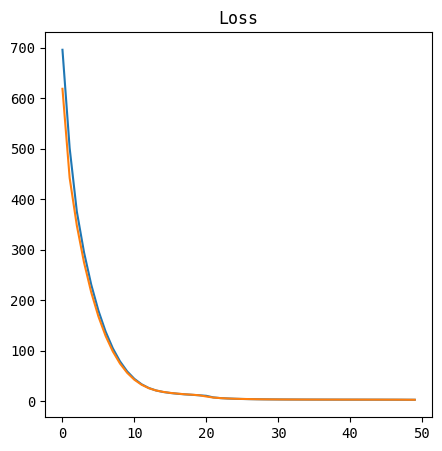

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(history.history["loss"], label="train")
ax.plot(history.history["val_loss"], label="validation")
ax.set_title("Loss")

Tenemos en total 6 salidas, una para cada paso de tiempo en la secuencia de entrada. Cada salida es una predicción de la temperatura para ese paso de tiempo.

In [43]:
many_to_many_preds = many_to_many.predict(test_data.values.reshape(-1, 6, 1))
many_to_many_preds = many_to_many_preds.reshape(-1, 6)
many_to_many_preds = pd.DataFrame(many_to_many_preds, columns=output_vars)
many_to_many_preds.set_index(test_label.index, inplace=True)
many_to_many_preds.head()

50/50 [==============================] - 0s 2ms/step


,next_temp,next_temp_2h,next_temp_3h,next_temp_4h,next_temp_5h,next_temp_6h
date,,,,,,
2024-04-15 12:00:00,32.863689,34.001083,34.322754,33.884865,33.021191,31.893316
2024-04-15 13:00:00,32.326862,33.431839,33.653709,33.223110,32.401199,31.340570
2024-04-15 14:00:00,31.682358,32.649841,32.817822,32.462223,31.761164,30.843271
2024-04-15 15:00:00,30.396671,31.113420,31.162914,30.942083,30.468163,29.813776
2024-04-15 16:00:00,29.088783,29.436077,29.442154,29.432806,29.266644,28.958115


Ahora vamos a comparar los resultados obtenidos hora a hora con los datos reales.

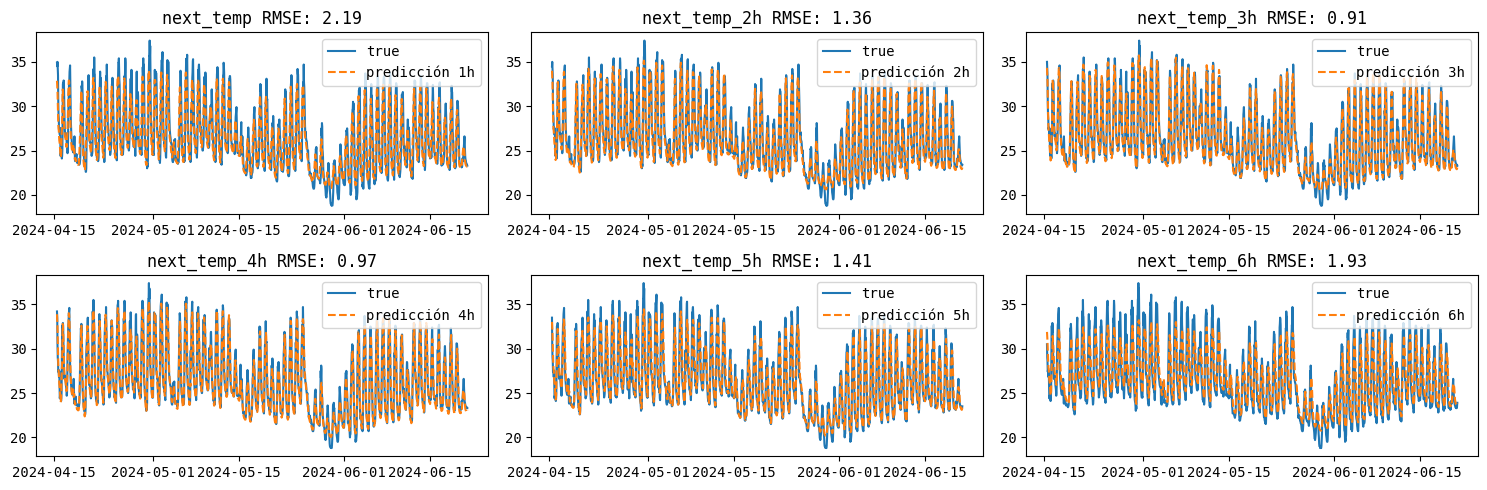

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.plot(test_label.iloc[:, i], label="true")
    ax.plot(many_to_many_preds.iloc[:, i], label=f"predicción {i+1}h", ls="--")
    rmse = np.sqrt(
        np.mean((test_label.iloc[:, i] - many_to_many_preds.iloc[:, i]) ** 2)
    )
    ax.set_title(f"{output_vars[i]} RMSE: {rmse:.2f}")
    ax.legend()
fig.tight_layout()